In [1]:
import numpy as np

from scipy.interpolate import interp1d
from scipy import stats

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")

import time
timeformat = "%Y%m%d-%H%M%S"
#timestr = time.strftime(timeformat)


from IPython.utils.path import ensure_dir_exists
fdir = 'figs/'
ensure_dir_exists(fdir)
resdir = 'res/'
ensure_dir_exists(resdir)

import RBMF as rbmf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
T     = 300
N     = 1000
frac  = 1.

seed0 = 0

Iinit0 = np.array(3)
iota0  = 0.2
rho0   = 0.02
delta0 = 0.01

figsize = (14,8)

In [3]:
params = {'T':    T, 
          'N':    N,
          'frac': frac}
freeparams = {'iota':  iota0,
              'rho':   rho0,
              'delta': delta0,
              'Iinit': Iinit0,
              'seed':  seed0}

In [4]:
def updateStates(rExc, S, I, R, D):
    if rExc == 0:         # Infection
        S -= 1
        I += 1
        return np.array(S), np.array(I), np.array(R), np.array(D)
    if rExc == 1:         # Recovery
        I -= 1
        R += 1
        return np.array(S), np.array(I), np.array(R), np.array(D)
    if rExc == 2:         # Death
        I -= 1
        D += 1
        return np.array(S), np.array(I), np.array(R), np.array(D)
    
def updatePropensities(S, I, R, D, N, iota, rho, delta):
    kappa = np.zeros(3)
    kappa[0] = S*I * iota/N # Infection
    kappa[1] =   I * rho    # Recovery
    kappa[2] =   I * delta  # Death
    return kappa

SIRD = rbmf.ModelSSA(name="SIRD",
                     params=params,
                     freeparams=freeparams,
                     update_states=updateStates,
                     update_propensities=updatePropensities)

## Data

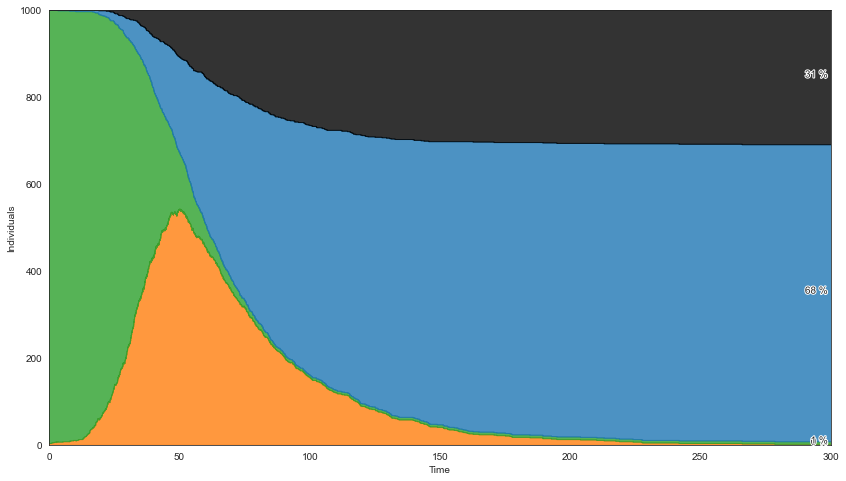

In [5]:
t0, S0, I0, R0, D0 = SIRD.simulate(freeparams)
fig = SIRD.plot(N, T, t0, S0, I0, R0, D0, ptitle=None, figsize=figsize, plegend=False)

## Distances

In [40]:
dfAll = interp1d(t0, (S0,I0,R0,D0), kind='previous', axis=- 1, fill_value='extrapolate', assume_sorted=True)
dfI   = interp1d(t0, I0, kind='previous', axis=- 1, fill_value='extrapolate', assume_sorted=True)
dfS   = interp1d(t0, S0, kind='previous', axis=- 1, fill_value='extrapolate', assume_sorted=True)
dfD   = interp1d(t0, D0, kind='previous', axis=- 1, fill_value='extrapolate', assume_sorted=True)

incI = -dfS((np.arange(T)))[1:] + dfS((np.arange(T)))[:-1]
incD =  dfD((np.arange(T)))[1:] - dfD((np.arange(T)))[:-1]

def distAllTabs(t, S, I, R, D):
    return (np.abs(dfAll(t) - [S,I,R,D])).sum()/(3*T*N) + np.abs(t0[-1] - t[-1])/T

def distAllabs(t, S, I, R, D):
    dfAlls = interp1d(t, (S, I, R, D), kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    tu  = np.unique(np.hstack((t0,t,T)))
    dtu = tu[1:] - tu[:-1] 
    return (np.abs(dfAll(tu[:-1]) - dfAlls(tu[:-1]))*dtu).sum()/(8*N*T)

def distAll2(t, S, I, R, D):
    dfAlls = interp1d(t, (S, I, R, D), kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    tu  = np.unique(np.hstack((t0,t,T)))
    dtu = tu[1:] - tu[:-1] 
    return np.sqrt(np.abs(dfAll(tu[:-1]) - dfAlls(tu[:-1]))**2 * dtu).sum()/(8*N*T)


def distIT2(t, S, I, R, D):
    return np.sqrt( ((dfI(t) - I)**2).sum())/(T*N) + np.abs(t0[-1] - t[-1])/T


def distIncIabs(t, S, I, R, D):
    dfs = interp1d(t, S, kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    incIs = -dfs((np.arange(T)))[1:] + dfs((np.arange(T)))[:-1]
    return np.abs(incI - incIs).sum()/(2*N)

def distIncID2(t, S, I, R, D):
    dfs = interp1d(t, S, kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    dfd = interp1d(t, D, kind='previous', axis=- 1, copy=True, fill_value='extrapolate', assume_sorted=True)
    
    incIs = -dfs((np.arange(T)))[1:] + dfs((np.arange(T)))[:-1]
    incDs =  dfd((np.arange(T)))[1:] - dfd((np.arange(T)))[:-1]
    return np.sqrt( np.sum((incI - incIs)**2) +  np.sum((incD - incDs)**2))/(4*N)

# Parameter Estimation (Model known) with vanillaABC

In [7]:
SIRDiota = rbmf.ModelSSA(name="SIRDiota",
                         params={'T': T, 'N': N, 'frac': frac,'rho': rho0, 'delta': delta0, 'Iinit': Iinit0},
                         freeparams={'iota': 0.2},
                         update_states=updateStates,
                         update_propensities=updatePropensities)

In [8]:
model = SIRDiota
dist = distAll2
M = 10
priors = stats.uniform(0,1) 

In [9]:
tolerances = [1.0, 0.5]#, 0.25, 0.1, 0.075, 0.05, 0.025 ]
runs = len(tolerances)
allSamples   = np.zeros((runs, M))
allDistances = np.zeros((runs, M))
allZ         = np.zeros(runs)

for r in range(runs):
    print(f'tolerance: {tolerances[r]}')
    samples, distances, z = rbmf.vanillaABC(model, 1, priors, tolerances[r], dist, 1., M)
    allSamples[r,:] = samples
    allDistances[r,:] = distances
    allZ[r] = z
    print('\n')
    fn = 'vanillaABC_' + model.name + f'({model.formulation})_' + f'tol{tolerances[r]}_M{M}_' + time.strftime(timeformat)
    np.savez(resdir + fn, samples=samples, distances=distances, z=z)
fn = 'vanillaABC_' + model.name + f'({model.formulation})_' + f'RUNS_M{M}_' + time.strftime(timeformat)    
np.savez(resdir + fn, allSamples=allSamples, allDistances=allDistances, allZ=allZ, tolerances=tolerances)

tolerance: 1.0
(acc.:        9 / total:       10)

tolerance: 0.5
(acc.:        9 / total:       10)



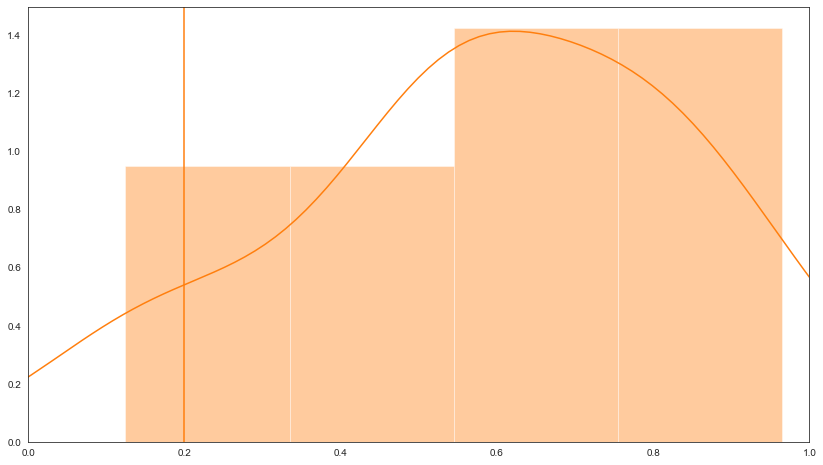

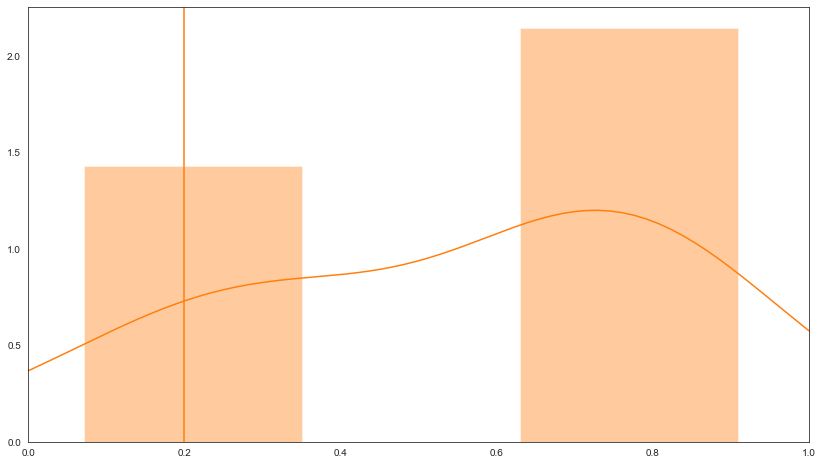

In [10]:
for r in range(runs):
    plt.figure(figsize=figsize)
    sns.distplot(allSamples[r,:], color='tab:orange')
    #plt.hist(allSamples[r,:], color='tab:orange', alpha=0.6)
    plt.axvline(iota0, c='tab:orange')
    plt.xlim((0,1))
    plt.show()

    #plt.figure(figsize=figsize)
    #plt.plot(distances, c='blue')
    #plt.show()

## with ODE

In [22]:
def deriv(t, Y, ny, iota, rho, delta, seed=None):
    S, I, R, D = np.split(Y, np.cumsum(ny)[:-1])
    
    dSdt = -S*I*iota
    dIdt =  S*I*iota - (rho+delta) * I
    dRdt =              rho        * I
    dDdt =                  delta  * I
    
    return np.concatenate((dSdt, dIdt, dRdt, dDdt))

SIRDiotaODE = rbmf.ModelODE(name="SIRDiota",
                            params={'T': T, 'N': N, 'frac': frac,'rho': rho0, 'delta': delta0, 'Iinit': Iinit0},
                            freeparams={'iota': 0.2},
                            deriv=deriv)

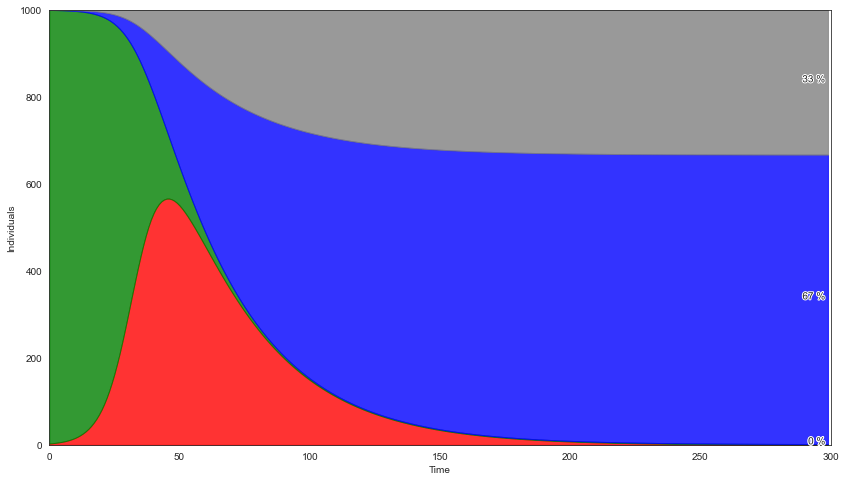

0.01648398446972626
0.012961425673489384


In [41]:
t, S, I, R, D = SIRDiotaODE.simulate({'iota': 0.2})
fig = SIRDiotaODE.plot(N, T, t, S, I, R, D, ptitle=None, figsize=figsize, plegend=False)
print(distAll2(t, S, I, R, D))
print(distIncID2(t, S, I, R, D))

In [42]:
model = SIRDiotaODE
#dist = distAll2
dist = distIncID2
M = 1000
priors = stats.uniform(0,1) 

In [43]:
tolerances = [1.0, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025]
runs = len(tolerances)
allSamples   = np.zeros((runs, M))
allDistances = np.zeros((runs, M))
allZ         = np.zeros(runs)

for r in range(runs):
    print(f'tolerance: {tolerances[r]}')
    samples, distances, z = rbmf.vanillaABC(model, 1, priors, tolerances[r], dist, 1., M)
    allSamples[r,:] = samples
    allDistances[r,:] = distances
    allZ[r] = z
    print('\n')
    fn = 'vanillaABC_' + model.name + f'({model.formulation})_' + f'tol{tolerances[r]}_M{M}_' + time.strftime(timeformat)
    np.savez(resdir + fn, samples=samples, distances=distances, z=z)
fn = 'vanillaABC_' + model.name + f'({model.formulation})_' + f'RUNS_M{M}_' + time.strftime(timeformat)    
np.savez(resdir + fn, allSamples=allSamples, allDistances=allDistances, allZ=allZ, tolerances=tolerances)

tolerance: 1.0
(acc.:      999 / total:     1000)

tolerance: 0.5
(acc.:      999 / total:     1000)

tolerance: 0.25
(acc.:      999 / total:     1000)

tolerance: 0.1
(acc.:      999 / total:     1144)

tolerance: 0.075
(acc.:      999 / total:     2133)

tolerance: 0.05
(acc.:      999 / total:     3261)

tolerance: 0.025
(acc.:      999 / total:    11877)



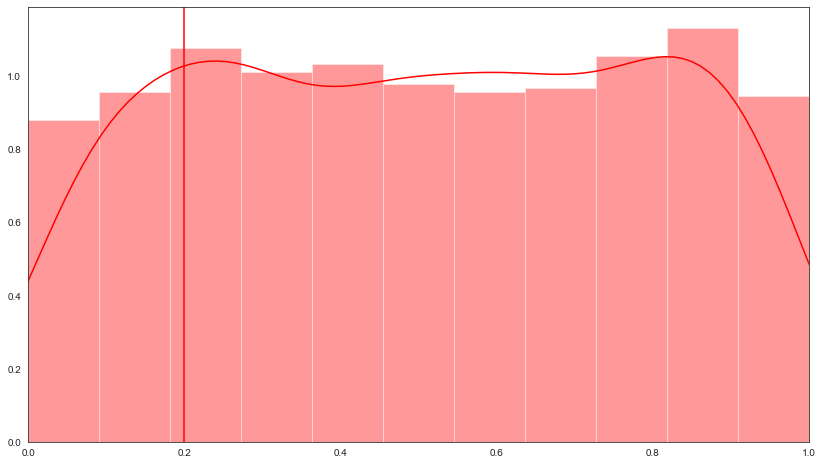

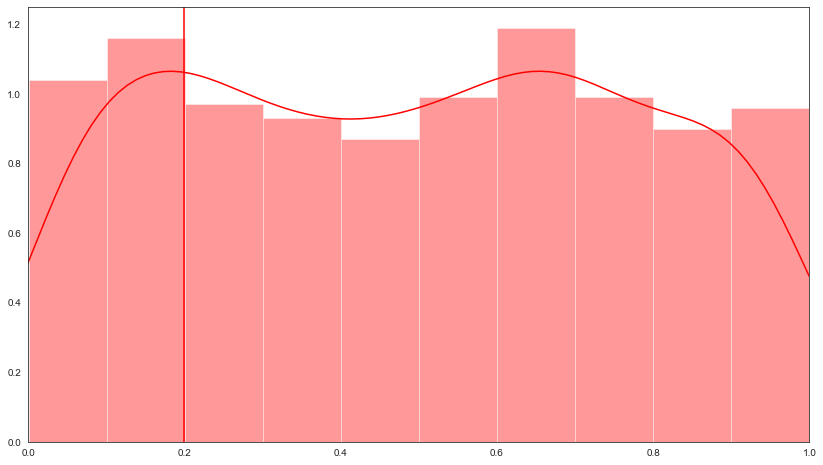

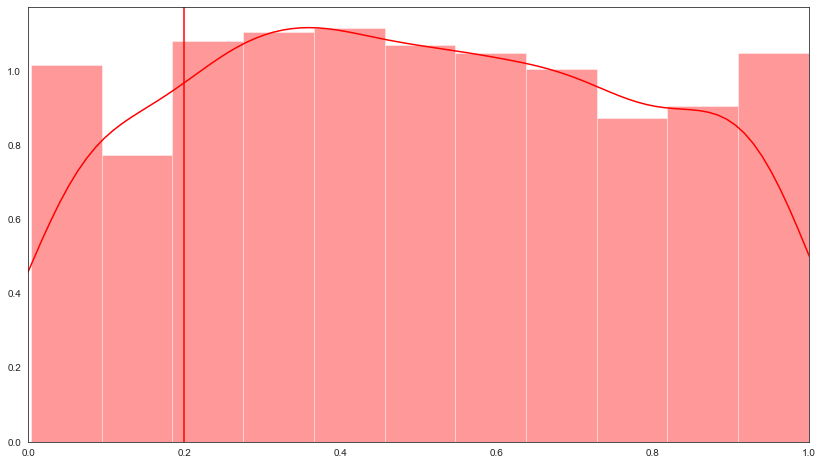

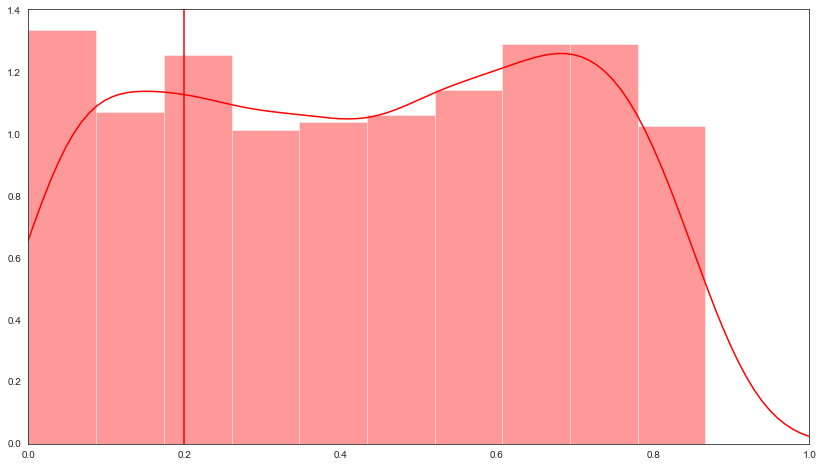

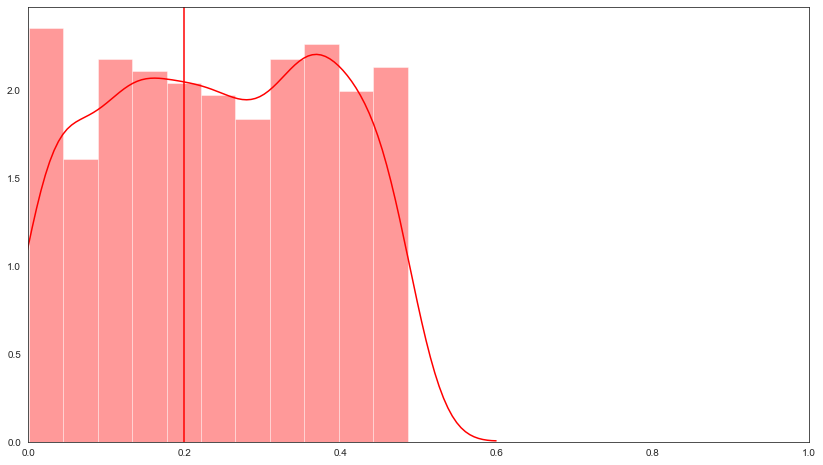

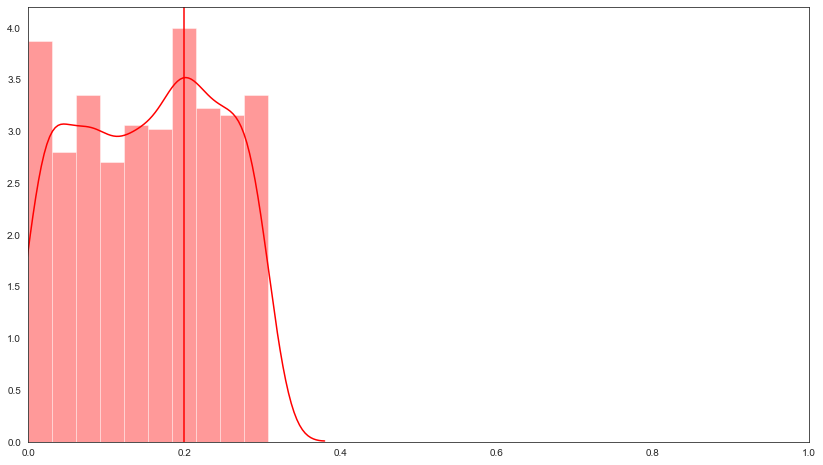

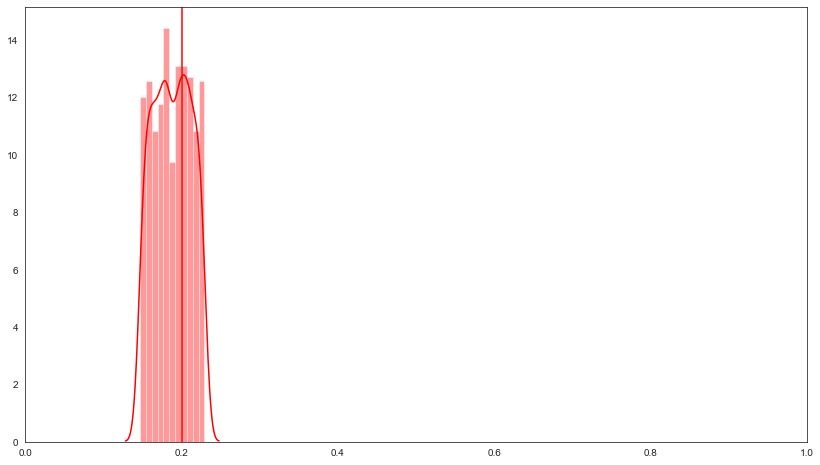

In [44]:
for r in range(runs):
    plt.figure(figsize=figsize)
    sns.distplot(allSamples[r,:], color='red')
    #plt.hist(allSamples[r,:], color='red', alpha=0.6)
    plt.axvline(iota0, c='red')
    plt.xlim((0,1))
    plt.show()

    #plt.figure(figsize=figsize)
    #plt.plot(distances, c='blue')
    #plt.show()